# Chapter 1: Singular Value Decomposition (SVD)¶

Course title:

**MECH 575T: Data-driven modeling and control (Self-directed)**

## Eigenfaces Example

Based on Section 1.6 of the book **Data-Driven Science and Engineering, by Steve Brunton**

## Contents

 1. Download Image Database
 - Load images from files
 - Make a composite image of faces
 - Combine data into train and test sets
 - Compute average face image
 - Visualize eigenfaces
 - Approximate test-image
 - Try Reconstucting a new image from a different distribution
 - Projection onto PCA modes

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
from platform import python_version
python_version()

'3.6.7'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## 8. Eigenfaces Example

PCA is applied to a large library of facial images to extract the most dominant correlations between images.

### Download Image Database

Extended Yale Face Database B contains 16128 images of 28 human subjects under 9 poses and 64 illumination conditions.

In this example we use images of 38 individuals (28 from the extended
database, and 10 from the original database) under 9 poses and 64 lighting conditions.

Data is described and can be downloaded here:
http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html"

Download the file (85 MB) from this link, unzip and move the directory 'CroppedYale' and all subdirectories into a directory called 'data':
http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip

Images are separate files in portable gray map (PGM) format.

### Load images from files

In [4]:
n_persons = 38
n_poses = 9
n_conditions = 64

In [5]:
data_dir = 'data'
sub_dir = 'CroppedYale'

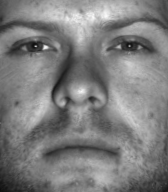

In [6]:
# Test load one train image
filename = 'yaleB01_P00A-005E-10.pgm'
filepath = os.path.join(data_dir, sub_dir, 'yaleB01', filename)
img = Image.open(filepath)
assert img.size == (168, 192)
img

In [7]:
# How to convert image to numpy array
img_array = np.array(img)
img_vector = img_array.flatten()
assert img_array.shape == (192, 168)
assert img_vector.shape == (192*168,)

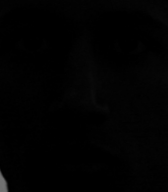

In [8]:
# Some image files are labeled '.bad' - Ignore them
filename = 'yaleB12_P00A-050E-40.pgm.bad'
filepath = os.path.join(data_dir, sub_dir, 'yaleB12', filename)
img = Image.open(filepath)
assert img.size == (168, 192)
img

In [9]:
def get_filenames_and_paths(img_dir, pathname, n=None):
    """Make a dictionary of filenames and paths that
    match the pathname pattern.
    """
    filepaths = {
        os.path.basename(path): path 
        for path in glob.glob(os.path.join(img_dir, pathname))
    }
    if n is not None:
        assert len(filepaths) == n

    return filepaths


def load_images_from_dir(img_dir, pathname, n=None, size=None):
    """Make a dictionary containing the images found in
    the directory with the filenames that match the 
    pathname pattern.
    """
    filepaths = get_filenames_and_paths(img_dir, pathname, n)
    images = {}
    for filename, filepath in filepaths.items():
        img = Image.open(filepath)
        assert img.size == size
        images[filename] = img.copy()
        img.close()

    return images


def load_all_images(img_dirs, pathname, n=None, size=None, 
                    show=False):
    all_images = {}
    for name, img_dir in img_dirs.items():
        images = load_images_from_dir(img_dir, pathname, n=n, 
                                      size=size)
        if show:
            print(f"{img_dir}: {len(images)} images")
        all_images[name] = images
    return all_images

In [10]:
img_dir_names = [
    'yaleB39', 'yaleB01', 'yaleB02', 'yaleB03', 'yaleB04', 
    'yaleB05', 'yaleB06', 'yaleB07', 'yaleB08', 'yaleB09', 
    'yaleB10', 'yaleB11', 'yaleB12', 'yaleB13', 'yaleB15',  # 14 is missing
    'yaleB16', 'yaleB17', 'yaleB18', 'yaleB19', 'yaleB20', 
    'yaleB21', 'yaleB22', 'yaleB23', 'yaleB24', 'yaleB25', 
    'yaleB26', 'yaleB27', 'yaleB28', 'yaleB29', 'yaleB30', 
    'yaleB31', 'yaleB32', 'yaleB33', 'yaleB34', 'yaleB35', 
    'yaleB36', 'yaleB37', 'yaleB38']
img_dirs = {name: os.path.join(data_dir, 'CroppedYale', name)
            for name in img_dir_names}
print(f"Number of image sub-directories: {len(img_dirs)}")
assert len(img_dirs) == n_persons

Number of image sub-directories: 38


In [11]:
# Load all images in different lighting conditions
pathname = 'yale???_P00A????????.pgm'
all_images = load_all_images(img_dirs, pathname, size=(168, 192))
n_images = sum([len(x) for x in all_images.values()])
print(f"{n_images} images loaded")

# Load 'bad' images
#pathname = 'yale*.pgm.bad'
#bad_images = load_all_images(img_dirs, pathname, size=(168, 192))
#n_bad = sum([len(x) for x in bad_images.values()])
#print(f"{n_bad} bad images loaded")

2414 images loaded


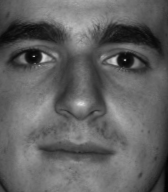

In [12]:
# Images are stored in a dictionary of dictionaries
all_images['yaleB39']['yaleB39_P00A+000E+00.pgm']

In [13]:
names = list(all_images.keys())
assert names == img_dir_names

train_names = names[:36]
test_names = names[36:]
test_names

['yaleB37', 'yaleB38']

### Make a composite image of faces

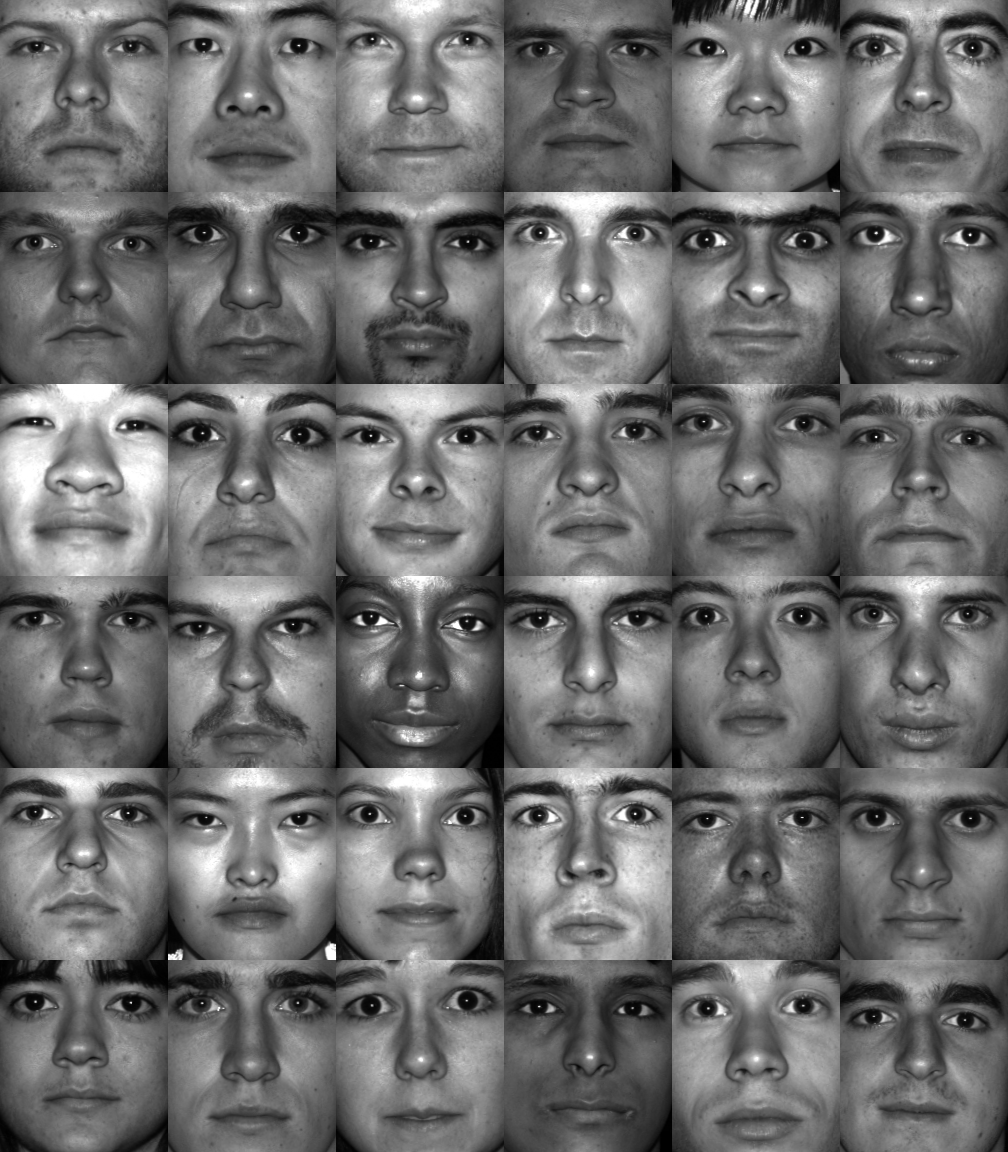

In [14]:
# Make a composite image from images of each face
m = 168
n = 192
all_persons = np.zeros((n*6, m*6))
all_persons.size

row, col = (0, 0)
for i, name in enumerate(sorted(train_names)):
    image = all_images[name][f'{name}_P00A+000E+00.pgm']
    all_persons[row:row+n, col:col+m] = image
    col += m
    if col >= m*6:
        row, col = row + n, 0

composite_faces = Image.fromarray(np.uint8(all_persons))
filename = 'composite.jpg'
filepath = os.path.join(plot_dir, filename)
composite_faces.save(filepath)
composite_faces

In [15]:
# Intensity range
all_persons.min(), all_persons.max()

(0.0, 255.0)

In [16]:
n_images

2414

### Combine data into train and test sets

In [17]:
# Prepare the data matrix of training images
image_size = n*m
n_train = sum([len(all_images[name]) for name in train_names])
x_train = np.zeros((image_size, n_train), dtype='i8')
image_index_train = {}
k = 0
for name in train_names:
    images = all_images[name]
    for i, (filename, image) in enumerate(images.items()):
        img_vector = np.array(image).flatten()
        assert img_vector.dtype == 'uint8'
        assert img_vector.max() < 256
        x_train[:, k] = img_vector.astype('uint8')
        image_index_train[(name, filename)] = k
        k += 1
image_index_train = pd.Series(image_index_train)
print(f"X matrix size: {x_train.shape}")

X matrix size: (32256, 2286)


In [18]:
x_train.min(), x_train.max()

(0, 255)

In [19]:
# Prepare the test data matrix
n_test = sum([len(all_images[name]) for name in test_names])
x_test = np.zeros((image_size, n_test), dtype='i8')
image_index_test = {}
k = 0
for name in test_names:
    images = all_images[name]
    for i, (filename, image) in enumerate(images.items()):
        img_vector = np.array(image).flatten()
        assert img_vector.dtype == 'uint8'
        assert img_vector.max() < 256
        x_test[:, k] = img_vector.astype('uint8')
        image_index_test[(name, filename)] = k
        k += 1
image_index_test = pd.Series(image_index_test)
print(f"Test matrix size: {x_test.shape}")

Test matrix size: (32256, 128)


### Compute average face image

In [20]:
avg_face = x_train.mean(axis=1)

In [21]:
avg_face.min(), avg_face.max()

(17.02755905511811, 99.4339457567804)

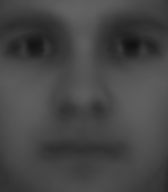

In [22]:
def image_from_vector(x, shape=(192, 168)):
    """Return a PIL image from a 1-dimensional data array
    """
    return Image.fromarray(x.reshape((n, m)).astype('uint8'))

avg_face_img = image_from_vector(avg_face, (n, m))
filename = 'avg_face.png'
avg_face_img.save(os.path.join(plot_dir, filename))
avg_face_img

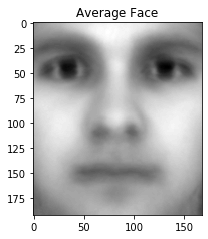

In [23]:
def show_image_plot(img, figsize=(3, 3.8), filename=None,
                    title=None, cmap='gray'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(plot_dir, filename))
    return plt.show()

show_image_plot(avg_face_img, title='Average Face',
                filename='fig_avg_face.png')

In [24]:
# If you want to clear images from memory
del all_images

### Visualize eigenfaces

In [25]:
import time

X = x_train - avg_face.reshape(-1, 1)

t0 = time.time()
U, S, VT = np.linalg.svd(X, full_matrices=0)
run_time = time.time() - t0
print(f"Run-time: {run_time:.2f} s")

Run-time: 54.24 s


In [26]:
assert X[5, 3] == x_train[5, 3] - avg_face[5]

In [27]:
U.shape, S.shape, VT.shape

((32256, 2286), (2286,), (2286, 2286))

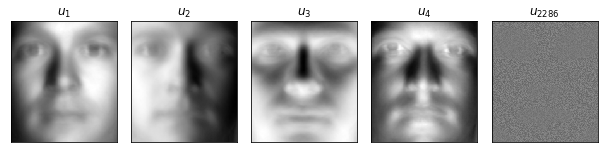

In [28]:
components = [0, 1, 2, 3, U.shape[1] - 1]

n_rows, n_cols = 1, len(components)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(1+n_cols*1.5, 3))
for i, ax in zip(components, axes):
    ax.imshow(U[:, i].reshape((n, m)), cmap='gray')
    ax.set_title("$u_{%d}$" % (i+1))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.tight_layout()
filename = 'eigenfaces.png'
filepath = os.path.join(plot_dir, filename)
plt.savefig(filepath)
plt.show()

### Approximate test-image
(Test images were not in training data)

In [42]:
x_test.shape

(32256, 128)

In [43]:
i_test = image_index_test.loc[
    ('yaleB37', 'yaleB37_P00A+000E+00.pgm')
]
i_test

38

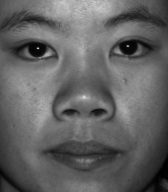

In [44]:
image_vector = x_test[:, i_test]
test_img = image_from_vector(image_vector)
filename = 'test_image.png'
test_img.save(os.path.join(plot_dir, filename))
test_img

In [45]:
r = 100

test_img_ms = image_vector.astype(float) - avg_face

t0 = time.time()

recon_face = avg_face + U[:, :r] @ U[:, :r].T @ test_img_ms

run_time = time.time() - t0
print(f"Run-time: {run_time:.2f} s")

Run-time: 24.32 s


In [46]:
recon_face.min(), recon_face.max()

(-0.916530100505554, 189.22637321751202)

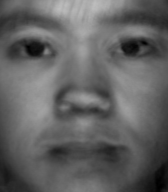

In [47]:
# Range of values in reconstructed image need to be clipped
recon_face_img = image_from_vector(recon_face.clip(0, 255))
filename = 'recon_image.png'
recon_face_img.save(os.path.join(plot_dir, filename))
recon_face_img

Reconstructing with r = 10...
Reconstructing with r = 25...
Reconstructing with r = 50...
Reconstructing with r = 100...
Reconstructing with r = 200...
Reconstructing with r = 400...
Reconstructing with r = 800...
Reconstructing with r = 1600...


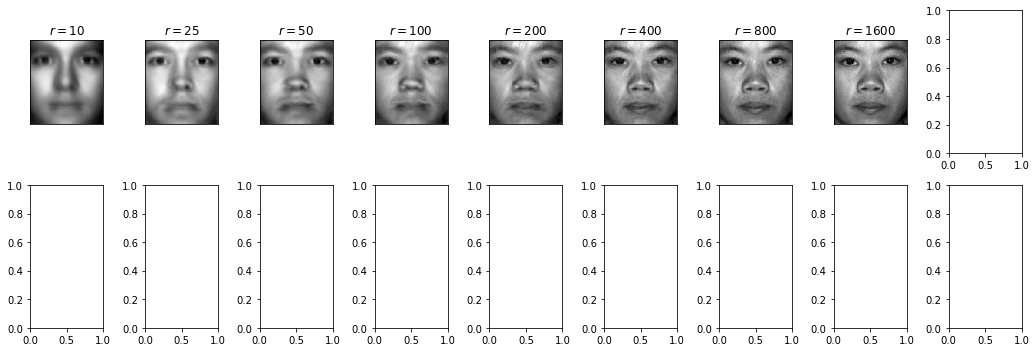

In [48]:
# Compare images reconstructed using eigenfaces
# basis of different order (r)
r_values = [10, 25, 50, 100, 200, 400, 800, 1600]

n_rows, n_cols = 2, (len(r_values) + 1) // n_rows
figsize = (1 + n_cols*1.5, 1 + n_rows*2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

row, col = 0, 0
for r in r_values:
    ax = axes[row, col]
    # Reconstruct approximate representation of test image
    test_img_ms = image_vector.astype(float) - avg_face
    print(f"Reconstructing with r = {r}...")
    recon_img_vector = avg_face + U[:, :r] @ U[:, :r].T @ test_img_ms
    recon_img = image_from_vector(recon_img_vector.clip(0, 255))
    ax.imshow(recon_img, cmap='gray')
    ax.set_title("$r = {%d}$" % r)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    col += 1
    if col == n_cols:
        row, col = row + 1, 0
    
plt.tight_layout()
filename = 'recon_faces_plot.png'
filepath = os.path.join(plot_dir, filename)
filename = 'recon_faces_plot.pdf'
filepath = os.path.join(plot_dir, filename)
plt.savefig(filepath)
plt.show()

### Try Reconstucting a new image from a different distribution

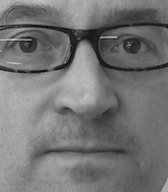

In [49]:
my_face = Image.open('data/my_face.jpg').convert('L')
assert my_face.size == (168, 192)
filename = 'my_face_bw.jpg'
filepath = os.path.join(plot_dir, filename)
my_face.save(filepath)
my_face

In [50]:
image_vector = np.array(my_face).flatten()
assert image_vector.shape == (32256,)

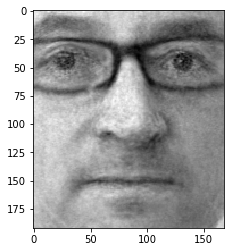

In [51]:
new_img_ms = image_vector.astype(float) - avg_face

r = 1600
recon_img_vector = avg_face + U[:, :r] @ U[:, :r].T @ new_img_ms

recon_my_face_img = image_from_vector(recon_img_vector.clip(0, 255))
plt.imshow(recon_my_face_img, cmap='gray')
plt.show()

In [52]:
filename = 'my_face_recon.jpg'
filepath = os.path.join(plot_dir, filename)
recon_my_face_img.save(filepath)

Reconstructing with r = 25...
Reconstructing with r = 100...
Reconstructing with r = 400...
Reconstructing with r = 1600...


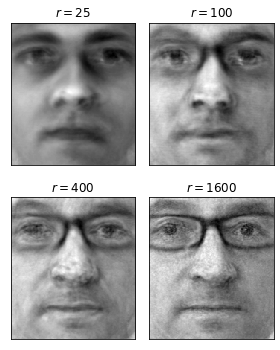

In [53]:
# Compare images reconstructed using eigenfaces
# basis of different order (r)
r_values = [25, 100, 400, 1600]

n_rows, n_cols = 2, (len(r_values) + 1) // n_rows
figsize = (1 + n_cols*1.5, 1 + n_rows*2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

row, col = 0, 0
for r in r_values:
    ax = axes[row, col]
    # Reconstruct approximate representation of test image
    new_img_ms = image_vector.astype(float) - avg_face
    print(f"Reconstructing with r = {r}...")
    recon_img_vector = avg_face + U[:, :r] @ U[:, :r].T @ new_img_ms
    recon_img = image_from_vector(recon_img_vector.clip(0, 255))
    ax.imshow(recon_img, cmap='gray')
    ax.set_title("$r = {%d}$" % r)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    col += 1
    if col == n_cols:
        row, col = row + 1, 0
    
plt.tight_layout()
filename = 'recon_my_face_plot.png'
filepath = os.path.join(plot_dir, filename)
filename = 'recon_my_face_plot.pdf'
filepath = os.path.join(plot_dir, filename)
plt.savefig(filepath)
plt.show()

### Projection onto PCA modes

In [54]:
# Use this index to select images from training set
image_index_train.head()

yaleB39  yaleB39_P00A+000E-20.pgm    0
         yaleB39_P00A+010E-20.pgm    1
         yaleB39_P00A-015E+20.pgm    2
         yaleB39_P00A+005E-10.pgm    3
         yaleB39_P00A-130E+20.pgm    4
dtype: int64

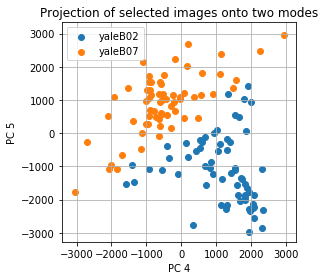

In [55]:
# Select by person IDs
persons = ['yaleB02', 'yaleB07']
selected_images = {person: x_train[:, image_index_train[person]]
                   for person in persons}

# Subtract average face
images_avg_sub = {name: selected_images[name] - avg_face.reshape(-1,1)
                        for name in persons}

# Select PCA modes to project onto
pca_modes = [4, 5]

pca_coords = {name: U[:, pca_modes].T.dot(images_avg_sub[name])
              for name in persons}

fig, ax = plt.subplots(figsize=(4.5, 4))
for name in persons:
    ax.scatter(pca_coords[name][0,:], pca_coords[name][1,:], label=name)

ax.set_xlabel(f"PC {pca_modes[0]}")
ax.set_ylabel(f"PC {pca_modes[1]}")
ax.set_title('Projection of selected images onto two modes')
ax.grid()
ax.legend()
plt.tight_layout()
filename = 'fig_1_21_py.pdf'
filepath = os.path.join(plot_dir, filename)
plt.savefig(filepath)
plt.show()

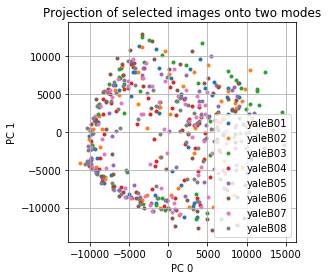

In [56]:
# Select by person IDs
persons = ['yaleB01', 'yaleB02', 'yaleB03', 'yaleB04', 'yaleB05', 
           'yaleB06', 'yaleB07', 'yaleB08']
selected_images = {person: x_train[:, image_index_train[person]]
                   for person in persons}

# Subtract average face
images_avg_sub = {name: selected_images[name] - avg_face.reshape(-1,1)
                        for name in persons}

# Select PCA modes to project onto
pca_modes = [0, 1]

pca_coords = {name: U[:, pca_modes].T.dot(images_avg_sub[name])
              for name in persons}

fig, ax = plt.subplots(figsize=(4.5, 4))
for name in persons:
    ax.scatter(pca_coords[name][0,:], pca_coords[name][1,:], 
               label=name, marker='.')

ax.set_xlabel(f"PC {pca_modes[0]}")
ax.set_ylabel(f"PC {pca_modes[1]}")
ax.set_title('Projection of selected images onto two modes')
ax.grid()
ax.legend()
plt.tight_layout()
filename = 'pca_face_projection.pdf'
filepath = os.path.join(plot_dir, filename)
plt.savefig(filepath)
plt.show()